In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [5]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'D:/ForME/3_Data/travel-time-prediction/checkpoints/cnn-lstm',
    }
}

In [6]:
def download_data(cfg, plot):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)
    
    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)

    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


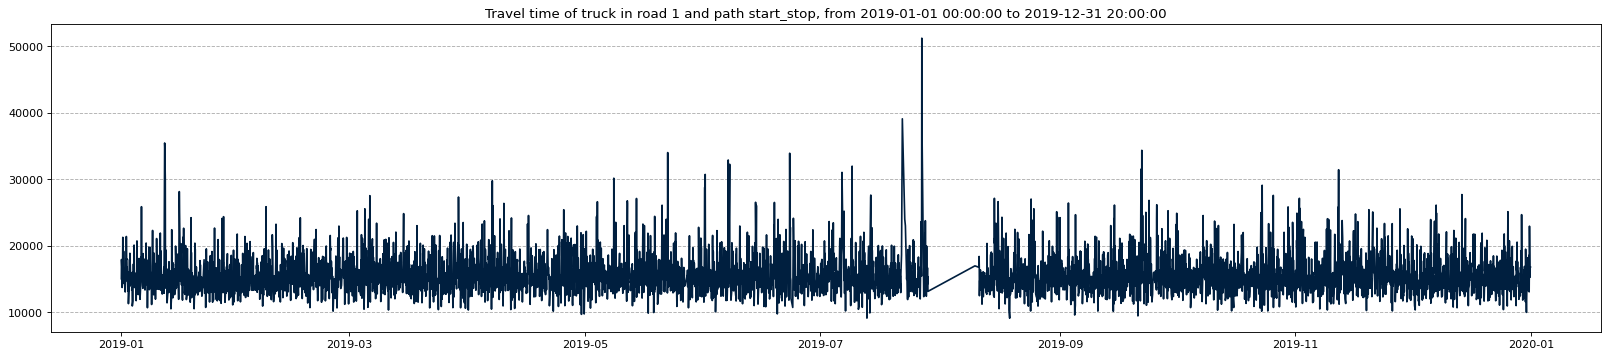

In [7]:
data_date, data_travel_time, num_data_points = download_data(cfg, cfg['plots']['show_plots'])

# Data preparation: normalize raw data

In [8]:
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Data preparation: generating training, test and validation data

In [10]:
print(type(normalize_data_travel_time))

<class 'numpy.ndarray'>


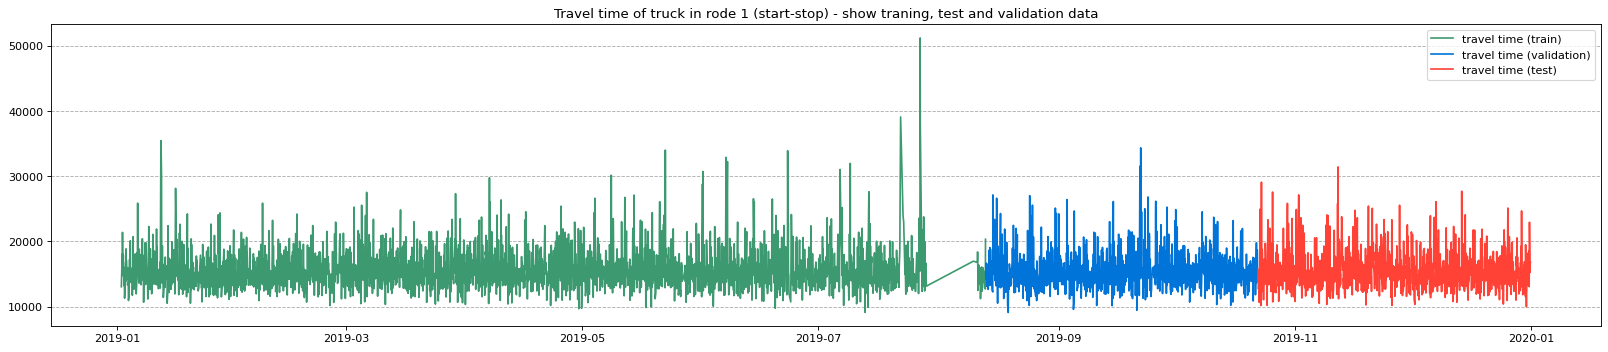

Train data shape: (4435, 21) (4435,)
Validation data shape: (1478, 21) (1478,)
Test data shape: (1479, 21) (1479,)


In [7]:
data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, _, split_val_index = generate_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)
print(f"Train data shape: {data_x_train.shape} {data_y_train.shape}")
print(f"Validation data shape: {data_x_val.shape} {data_y_val.shape}")
print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

In [8]:
# create class dataset
dataset_train = TravelTimeDataset(data_x_train, data_y_train)
dataset_val = TravelTimeDataset(data_x_val, data_y_val)
dataset_test = TravelTimeDataset(data_x_test, data_y_test)

In [9]:
print(f"Train data for model shape: {dataset_train.x.shape} {dataset_train.y.shape}")
print(f"Validation data for model shape: {dataset_val.x.shape} {dataset_val.y.shape}")
print(f"Test data for model shape: {dataset_test.x.shape} {dataset_test.y.shape}")

Train data for model shape: (4435, 1, 21) (4435,)
Validation data for model shape: (1478, 1, 21) (1478,)
Test data for model shape: (1479, 1, 21) (1479,)


# Define CNN-LSTM model

In [10]:
#1
# class CNN_Block(nn.Module):
#     def __init__(self):
#         super(CNN_Block, self).__init__()
#         self.conv_1 = nn.Conv1d(1, 64, kernel_size=2, stride=1)
#         self.conv_2 = nn.Conv1d(64, 128, kernel_size=2, stride=1)
#         self.maxpool_1 = nn.MaxPool1d(kernel_size=2)
    
#     def forward(self, x):
#         out = F.relu(self.conv_1(x))
#         out = F.relu(self.conv_2(out))
#         out = self.maxpool_1(out)
#         # out = out.view(-1, 128)

#         return out

In [11]:
# 2
# class CNN_Block(nn.Module):
#     def __init__(self):
#         super(CNN_Block, self).__init__()
#         self.conv_1 = nn.Conv1d(1, 64, kernel_size=2, stride=1)
#         self.conv_2 = nn.Conv1d(64, 64, kernel_size=2, stride=1)
#         self.maxpool_1 = nn.MaxPool1d(kernel_size=2)
    
#     def forward(self, x):
#         out = F.relu(self.conv_1(x))
#         out = F.relu(self.conv_2(out))
#         out = self.maxpool_1(out)
#         # out = out.view(-1, 128)

#         return out

In [12]:
# 3
# class CNN_Block(nn.Module):
#     def __init__(self):
#         super(CNN_Block, self).__init__()
#         self.conv_1 = nn.Conv1d(1, 64, kernel_size=2, stride=1)
#         self.conv_2 = nn.Conv1d(64, 32, kernel_size=2, stride=1)
#         self.maxpool_1 = nn.MaxPool1d(kernel_size=2)
    
#     def forward(self, x):
#         out = F.relu(self.conv_1(x))
#         out = F.relu(self.conv_2(out))
#         out = self.maxpool_1(out)
#         # out = out.view(-1, 128)

#         return out

In [13]:
# 1
# class LSTM_Blcok(nn.Module):
#     def __init__(self, lstm_hidde_size, lstm_num_layers):
#         super(LSTM_Blcok, self).__init__()
#         self.lstm_1 = nn.LSTM(
#             input_size=128,
#             hidden_size=128,
#             num_layers=1,
#             batch_first=True
#         )
#         self.fc_1 = nn.Linear(128, 64)
#         self.dropout_1 = nn.Dropout(0.2)

#     def forward(self, x):
#         out, _ = self.lstm_1(x)
#         out = out[:, -1, :]
#         out = F.relu(self.fc_1(out))
#         out = self.dropout_1(out)

#         return out

In [14]:
# 2
# class LSTM_Blcok(nn.Module):
#     def __init__(self, lstm_hidde_size, lstm_num_layers):
#         super(LSTM_Blcok, self).__init__()
#         self.lstm_1 = nn.LSTM(
#             input_size=128,
#             hidden_size=200,
#             num_layers=1,
#             batch_first=True
#         )
#         self.fc_1 = nn.Linear(200, 64)
#         self.dropout_1 = nn.Dropout(0.2)
#         self.fc_2 = nn.Linear(64, 32)
#         self.dropout_2 = nn.Dropout(0.1)

#     def forward(self, x):
#         out, _ = self.lstm_1(x)
#         out = out[:, -1, :]
#         out = F.relu(self.fc_1(out))
#         out = self.dropout_1(out)
#         out = F.relu(self.fc_2(out))
#         out = self.dropout_2(out)

#         return out

In [15]:
# 3
# class LSTM_Blcok(nn.Module):
#     def __init__(self, lstm_hidde_size, lstm_num_layers):
#         super(LSTM_Blcok, self).__init__()
#         self.lstm_1 = nn.LSTM(
#             input_size=32,
#             hidden_size=lstm_hidde_size,
#             num_layers=lstm_num_layers,
#             batch_first=True
#         )
#         self.lstm_2 = nn.LSTM(
#             input_size=lstm_hidde_size,
#             hidden_size=lstm_hidde_size,
#             num_layers=lstm_num_layers,
#             batch_first=True
#         )
#         self.flatten = nn.Flatten()
#         self.fc_1 = nn.Linear(lstm_hidde_size, 64)
#         self.dropout_1 = nn.Dropout(0.2)
#         self.fc_2 = nn.Linear(64, 16)
#         self.dropout_2 = nn.Dropout(0.1)

#     def forward(self, x):
#         out, _ = self.lstm_1(x)
#         out, _ = self.lstm_2(out)
#         out = out[:, -1, :]
#         out = self.flatten(out)
#         out = F.relu(self.fc_1(out))
#         out = self.dropout_1(out)
#         out = F.relu(self.fc_2(out))
#         out = self.dropout_2(out)

#         return out

In [16]:
# class CNN_LSTM(nn.Module):
#     def __init__(self, lstm_hidde_size, lstm_num_layers):
#         super(CNN_LSTM, self).__init__()
#         self.cnn_block = CNN_Block()
#         self.lstm_block = LSTM_Blcok(lstm_hidde_size=lstm_hidde_size, lstm_num_layers=lstm_num_layers)
#         self.out_block = nn.Linear(32, 1)

#     def forward(self, x):
#         # CNN block
#         out = self.cnn_block(x)
#         out = out.view(out.shape[0], out.shape[2], out.shape[1])

#         # LSTM block
#         out = self.lstm_block(out)
        
#         # Output layer
#         out = self.out_block(out)

#         return out

In [17]:
class CNN_Block(nn.Module):
    def __init__(self, mode):
        super(CNN_Block, self).__init__()
        self.conv_1_out = [32, 64, 128]
        self.conv_2_out = [32, 64, 128]
        self.conv_kernel_size = [2, 3]

        self.conv_1 = nn.Conv1d(1, self.conv_1_out[mode[0]], kernel_size=self.conv_kernel_size[mode[2]], stride=1)
        self.conv_2 = nn.Conv1d(self.conv_1_out[mode[0]], self.conv_2_out[mode[1]], kernel_size=self.conv_kernel_size[mode[2]], stride=1)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        out = self.maxpool_1(out)

        return out

In [18]:
class LSTM_Block(nn.Module):
    def __init__(self, mode):
        super(LSTM_Block, self).__init__()
        self.lstm_in = [32, 64, 128]
        self.lstm_hidden = [64, 128, 200, 256]
        self.linear_out = [32, 64]
        self.dropout = [0.1, 0.2, 0.3]

        self.lstm_1 = nn.LSTM(
            input_size=self.lstm_in[mode[0]],
            hidden_size=self.lstm_hidden[mode[1]],
            num_layers=1,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(self.lstm_hidden[mode[1]], self.linear_out[mode[2]])
        self.dropout_1 = nn.Dropout(self.dropout[mode[3]])

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out[:, -1, :]
        out = F.relu(self.fc_1(out))
        out = self.dropout_1(out)

        return out

In [19]:
class CNN_LSTM(nn.Module):
    def __init__(self, mode):
        super(CNN_LSTM, self).__init__()
        self.linear_in = [32, 64]
        self.cnn_block = CNN_Block(mode[0])
        self.lstm_block = LSTM_Block(mode[1])
        self.out_block = nn.Linear(self.linear_in[mode[1][2]], 1)

    def forward(self, x):
        # CNN block
        out = self.cnn_block(x)
        out = out.view(out.shape[0], out.shape[2], out.shape[1])

        # LSTM block
        out = self.lstm_block(out)
        
        # Output layer
        out = self.out_block(out)

        return out

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [21]:
# model = CNN_LSTM(lstm_hidde_size=cfg['model']['lstm_hidden_size'], lstm_num_layers=cfg['model']['lstm_num_layers'])
# model.apply(init_weights)
# if torch.cuda.is_available():
#     cfg['train']['device'] = 'cuda'
# else:
#     cfg['train']['device'] = 'cpu'
# print(f"Training model use the {cfg['train']['device']}")
# model = model.to(cfg['train']['device'])
# print(f"======================= [Summary Model] =======================")
# print(model)
# print(f"===============================================================")

# Model training

In [22]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

In [23]:
# train_losses, valid_losses, early_stopping, model = train(dataset_train, dataset_val, model, cfg)

In [24]:
# # visualize the loss as the network trained
# fig = plt.figure(figsize=(10,8))
# plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(valid_losses) + 1), valid_losses,label='Validation Loss')

# # find position of lowest validation loss
# minposs = np.where(valid_losses == early_stopping.val_loss_min)[0] + 1
# plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# plt.xlabel('epochs')
# plt.ylabel('loss')
# # plt.ylim(0, 0.5) # consistent scale
# plt.xlim(0, len(train_losses)+1) # consistent scale
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# Model evaluation

In [25]:
def eval(dataset_test, split_val_index, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    mse = mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1))))
    mae = mean_absolute_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))

    # print(f"MSE : {mse}")
    # print(f"RMSE : {rmse}")
    # print(f"MAE : {mae}")

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(dataset_test.y.reshape(-1, 1))
        to_plot_predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
        to_plot_data_date = data_date[split_val_index + cfg['data']['window_size']:]

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(to_plot_data_date, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(to_plot_data_date, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

In [26]:
# eval(dataset_test, split_val_index, scaler, model, cfg, 'lstm_6_0.787', True)

# Modified

In [27]:
save_path = 'D:/ForME/3_Data/travel-time-prediction/checkpoints'

In [28]:
mode = []
for idx_kernel_size in range(2):
    for idx_dropout in range(3):
        for idx_conv_1_out in range(3):
            for idx_conv_2_out in range(3):
                for idx_lstm_hidden in range(4):
                    for idx_linear_out in range(2):
                        mode.append([[idx_conv_1_out, idx_conv_2_out, idx_kernel_size], [idx_conv_2_out, idx_lstm_hidden, idx_linear_out, idx_dropout]])

In [29]:
# mode = [[[1, 2, 0], [2, 1, 0, 1]], [[1, 2, 0], [2, 1, 1, 1]], [[1, 2, 0], [2, 2, 0, 1]], [[1, 2, 0], [2, 2, 1, 1]]]

In [30]:
conv_1_out = [32, 64, 128]
conv_2_out = [32, 64, 128]
conv_kernel_size = [2, 3]
lstm_in = [32, 64, 128]
lstm_hidden = [64, 128, 200, 256]
linear_out = [32, 64]
dropout = [0.1, 0.2, 0.3]

result = []

for idx in range(len(mode)):
    print(f"model: {idx + 1}/{len(mode)}")
    mse_list, rmse_list, mae_list = [], [], []
    for count in range(10):
        model = CNN_LSTM(mode[idx])
        model.apply(init_weights)
        if torch.cuda.is_available():
            cfg['train']['device'] = 'cuda'
        else:
            cfg['train']['device'] = 'cpu'
        # print(f"Training model use the {cfg['train']['device']}")
        model = model.to(cfg['train']['device'])
        # print(f"======================= [Summary Model] =======================")
        # print(model)
        # print(f"===============================================================")

        train_losses, valid_losses, early_stopping, model = train(dataset_train, dataset_val, model, cfg, idx, count)

        mse, rmse, mae = eval(dataset_test, split_val_index, scaler, model, cfg, f"cnn_lstm_{idx}_{count}", False)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)

    avg_mse = sum(mse_list) / 10
    avg_rmse = sum(rmse_list) / 10
    avg_mae = sum(mae_list) / 10

    print(f"Name : CNN-{conv_1_out[mode[idx][0][0]]}-{conv_2_out[mode[idx][0][1]]}-kernel-{conv_kernel_size[mode[idx][0][2]]}-lstm-{lstm_hidden[mode[idx][1][1]]}-{linear_out[mode[idx][1][2]]}-drop-{dropout[mode[idx][1][3]]}")
    print(f"MSE : {avg_mse} || RMSE : {avg_rmse} || MAE : {avg_mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"CNN-{conv_1_out[mode[idx][0][0]]}-{conv_2_out[mode[idx][0][1]]}-kernel-{conv_kernel_size[mode[idx][0][2]]}-lstm-{lstm_hidden[mode[idx][1][1]]}-{linear_out[mode[idx][1][2]]}-drop-{dropout[mode[idx][1][3]]}",
        'mse': avg_mse,
        'rmse': avg_rmse,
        'mae': avg_mae,
    })

    df_tmp = pd.DataFrame(result)
    df_tmp.to_csv(save_path + '/report.csv', index=False)

model: 1/432
Name : CNN-32-32-kernel-2-lstm-64-32-drop-0.1
MSE : 6980469.923244283 || RMSE : 2642.0416956098375 || MAE : 1933.299447048259
model: 2/432
Name : CNN-32-32-kernel-2-lstm-64-64-drop-0.1
MSE : 7028922.666435525 || RMSE : 2651.1777615237597 || MAE : 1935.9056211134498
model: 3/432
Name : CNN-32-32-kernel-2-lstm-128-32-drop-0.1
MSE : 6946210.0202955585 || RMSE : 2635.538055665227 || MAE : 1923.9377845400718
model: 4/432
Name : CNN-32-32-kernel-2-lstm-128-64-drop-0.1
MSE : 6967694.062450218 || RMSE : 2639.621372822991 || MAE : 1934.1414029290968
model: 5/432
Name : CNN-32-32-kernel-2-lstm-200-32-drop-0.1
MSE : 7001438.092669529 || RMSE : 2646.00298158679 || MAE : 1935.6946053789584
model: 6/432
Name : CNN-32-32-kernel-2-lstm-200-64-drop-0.1
MSE : 6988873.75990627 || RMSE : 2643.619977096931 || MAE : 1929.5673024534124
model: 7/432
Name : CNN-32-32-kernel-2-lstm-256-32-drop-0.1
MSE : 7021507.966933486 || RMSE : 2649.7929519022755 || MAE : 1934.2364948303264
model: 8/432
Name : C